Develop a regression model using the `insurance.csv` dataset to predict `charges`. Evaluate the model's accuracy with the R-Squared Score. Then, apply the model to estimate `predicted_charges` for unseen data in `validation_dataset.csv`.

In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Loading the insurance dataset
insurance = pd.read_csv('https://raw.githubusercontent.com/KeithGalli/Regression-Example/refs/heads/master/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.924
1,18.0,male,33.770,1.0,no,Southeast,1725.5523
2,28.0,male,33.000,3.0,no,southeast,$4449.462
3,33.0,male,22.705,0.0,no,northwest,$21984.47061
4,32.0,male,28.880,0.0,no,northwest,$3866.8552


In [ ]:
# Task #1: Clean up the data

insurance_filled = insurance.dropna()

insurance_filled.loc[:, 'region'] = insurance_filled['region'].str.lower()

FEMALE = 'female'
MALE = 'male'
sex_map = {'F': FEMALE, 'M': MALE, 'woman': FEMALE, 'man': MALE}

insurance_filled.loc[:, 'sex'] = insurance_filled.sex.replace(sex_map)

# pd.set_option('future.no_silent_downcasting', True)

insurance_filled.loc[:, 'smoker'] = (insurance_filled.smoker == 'yes').astype('bool')

insurance_filled.loc[:, 'charges'] = insurance_filled.charges.str.replace('$', '').astype('float64')

In [ ]:
insurance_pos = insurance_filled.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)

In [ ]:
insurance_pos['charges'] = pd.to_numeric(insurance_pos['charges'], errors='coerce')
# insurance_pos = insurance_pos.drop('charges_numeric', axis=1)

In [ ]:
insurance_pos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1208 non-null   float64
 1   sex       1208 non-null   object 
 2   bmi       1208 non-null   float64
 3   children  1208 non-null   float64
 4   smoker    1208 non-null   object 
 5   region    1208 non-null   object 
 6   charges   1207 non-null   float64
dtypes: float64(4), object(3)
memory usage: 75.5+ KB


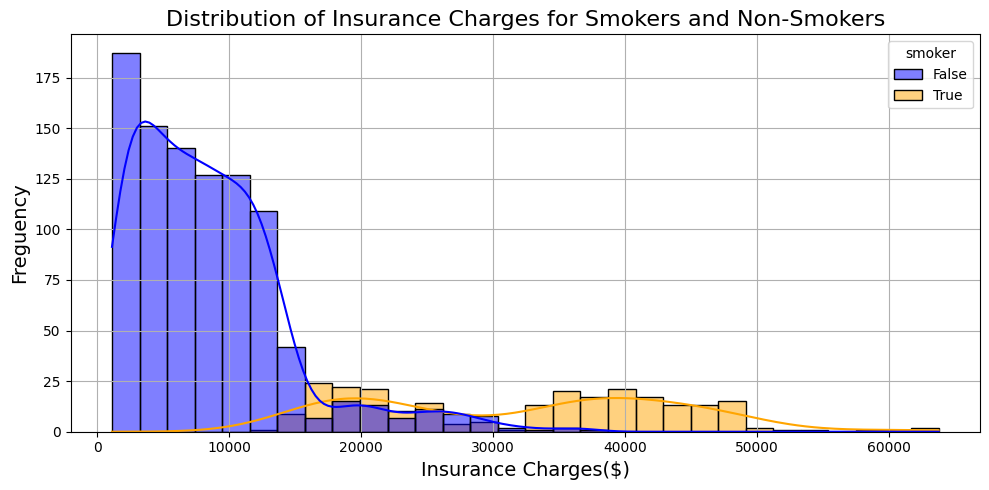

<Figure size 640x480 with 0 Axes>

In [ ]:
os.makedirs('result', exist_ok=True)
# Task #2: Exploratory Data Analysis (EDA)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = insurance_pos.copy()

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='charges', kde=True, hue='smoker', bins=30, palette=['blue', 'orange'])

plt.title('Distribution of Insurance Charges for Smokers and Non-Smokers', fontsize=16)
plt.xlabel('Insurance Charges($)', fontsize=14)
plt.ylabel('Freguency', fontsize=14)


plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('result/charges_distribution.png')

### Key Observations:
1. Non-Smokers (Blue):
   - The majority of insurance charges for non-smokers are below $10,000.
   - This group has a high frequency of lower charges

2. Smokers (Orange):
   - smokers show a wider distribution of insurance charges.
   - Many smokers have charges above $20,000, with some reaching up to \$60,000.
   - This suggess that smokers tend to have higher insurance charges compared to non-smokers.

This visualization highlights the impact of smoking on insurance charges, demonstrating higher costs for smokers.

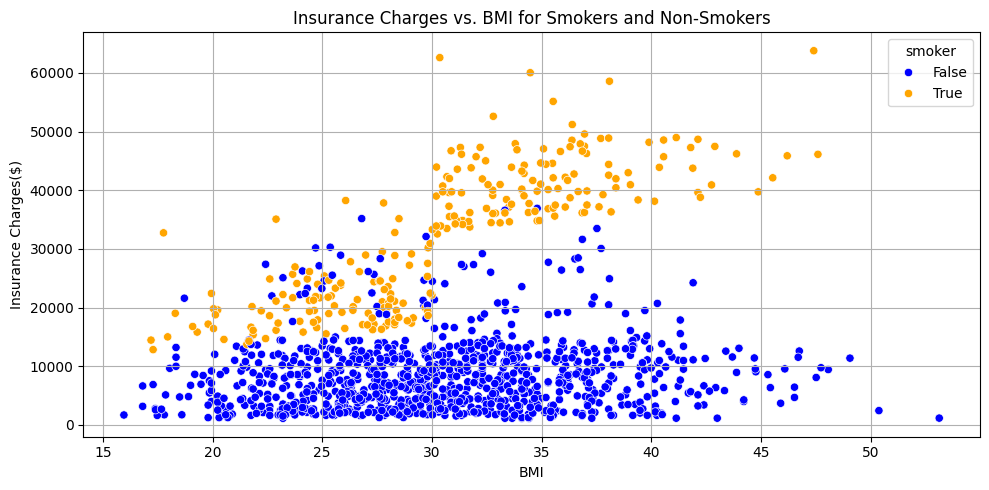

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='bmi', y="charges", hue='smoker', palette=['blue', 'orange'])
plt.title('Insurance Charges vs. BMI for Smokers and Non-Smokers')
plt.xlabel('BMI')
plt.ylabel('Insurance Charges($)')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('result/insurance vs. bmi.png')

### Key Observations:
1. Smokers (Orange Dots):
   - Generally have higher insurance charges compared to non-smokers.
   - The scatter plot shows a broader range of insurance charges across different BMI values.
   - There are smokers with insurance charges reaching up to $60,000.
2. Non-Smokers (Blue Dots):
  - Have lower insurance charges compared to smokers.
  - Most non-smokers have charges below \$20,000, irrespective of their BMI.
  - The distribution of insurance charges is more concentrated in the lower range.

### Trends:
- Impact of Smoking: The plot clearly demonstrates that smokers tend to incur higher insurance charges than non-smokers. This trend is consistent across different BMI values, highlighting the significant financial impact of smoking on insurance costs.

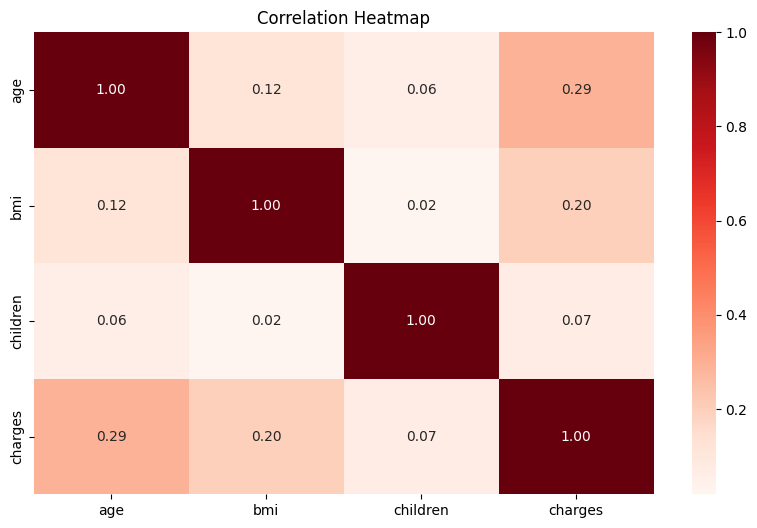

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns
corr = df[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='Reds', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
import plotly.express as px

fig = px.histogram(df, x='charges', color='smoker', marginal='box', # hover_data=df.columns,
                   title='Distribution of Insurance Charges for Smokers and Non-smokers',
                   labels={'Charges': 'Insurance Charges($)'}, nbins=40, color_discrete_sequence=['green', 'grey'])

fig.update_layout(bargap=0.1)

fig.show()
plt.savefig('result/charges_smoker.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
# task #3 - Prepare the data for a model fitting

df.sex = (df.sex == 'male').astype('int64')
df.smoker = (df.smoker == True).astype('int64')
dummies = pd.get_dummies(df['region'], prefix='region').astype('int64')
df = df.join(dummies)

In [ ]:
df_new = df.drop(['region', 'region_southeast'], axis=1)

In [ ]:
df_new = df_new.rename(columns={'sex': 'is_male'}).copy()

In [ ]:
df_new = df_new.dropna()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1207 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1207 non-null   float64
 1   is_male           1207 non-null   int64  
 2   bmi               1207 non-null   float64
 3   children          1207 non-null   float64
 4   smoker            1207 non-null   int64  
 5   charges           1207 non-null   float64
 6   region_northeast  1207 non-null   int64  
 7   region_northwest  1207 non-null   int64  
 8   region_southwest  1207 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 94.3 KB


In [ ]:
# class MeanPredictor:
#     def __init__(self):
#         self.mean = None

#     def fit(self, X, y):
#         self.mean = np.mean(y)

#     def predict(self, X):
#       return np.full(X.shape[0], self.mean)

# base_model = MeanPredictor()
# base_model.fit(X_train, y_train)
# base_mse = mean_squared_error(y_test, base_model.predict(X_test))


# base_mse

In [ ]:
# Task #4: Fit a linear regression model to our data


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

X = df_new.drop('charges', axis=1)
y = df_new['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score = r2_score(y_test, y_pred)

r2_score

0.7049323160872818

In [ ]:
def try_model(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  return r2

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Parameter grid for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perfrom grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=1, verbose=0)
grid_search.fit(X_train, y_train)

# Print the best parameters and Score
print(f'Best parameters: {grid_search.best_params_}')
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best score: 0.8585347409887365


In [ ]:
min(y_test), max(y_test), min(y_pred), max(y_pred)

(1149.3959, 58571.07448, 1335.040697544872, 47887.2323078159)

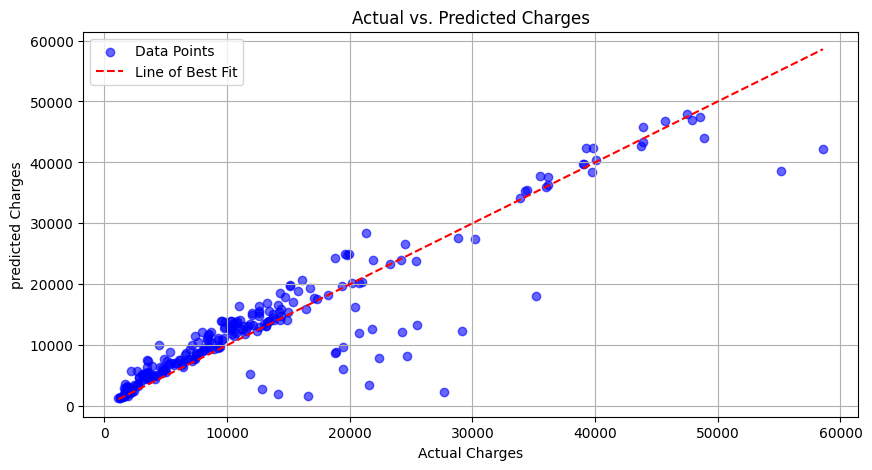

<Figure size 640x480 with 0 Axes>

In [ ]:
import os

os.makedirs('result', exist_ok=True)

from sklearn.metrics import r2_score

y_pred = grid_search.best_estimator_.predict(X_test)

# Visualization of Actual Vs. Predicted Charges

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Data Points')
plt.title('Actual vs. Predicted Charges')
plt.xlabel('Actual Charges')
plt.ylabel('predicted Charges')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Line of Best Fit')
plt.legend()
plt.grid()
plt.show()
plt.savefig('result/charges_distribution.png')

### Elements:
  - Blue Dots: Each dot represents a data point comparing the actual charge to the predicted charge.
  - Red Line: The line of best fit or the identity line (45-degree line), which indicates where points would lie if the predictions were perfect.
  
### Key Observation:
1. Alignment with Red Line:
  - If the blue dots are close to the red line, it means the model's predictions are very accurate.
  - The further the blue dots are from the red line, the larger the prediction errors.
2. Distribution:
   - The scatter plot helps visualize whether the model consistently overestimates or underestimates charges.
   - A random scatter around the red line indicates a well-performing model.
   

In [ ]:
def preprocess_df (data):
  data.loc[:, 'region'] = data['region'].str.lower()
  data.loc[:, 'sex'] = data.sex.replace(sex_map)
  data.loc[:, 'smoker'] = (data.smoker == 'yes').astype('int64')
  data.loc[:, 'sex'] = (data.sex == 'male').astype('int64')
  dummies = pd.get_dummies(data['region'], prefix='region').astype('int64')
  data = data.join(dummies)
  data = data.drop(['region', 'region_southeast'], axis=1)
  data = data.rename(columns={'sex': 'is_male'}.copy())
  return data

In [ ]:
# Use the trained model to predict charges for the data in validation_dataset.csv

val_df = pd.read_csv('https://raw.githubusercontent.com/KeithGalli/Regression-Example/refs/heads/master/validation_dataset.csv')

val_df.head()

,age,sex,bmi,children,smoker,region
0,18.0,female,24.090000,1.0,no,southeast
1,39.0,male,26.410000,0.0,yes,northeast
2,27.0,male,29.150000,0.0,yes,southeast
3,71.0,male,65.502135,13.0,yes,southeast
4,28.0,male,38.060000,0.0,no,southeast


In [ ]:
val_df_new = preprocess_df(val_df)

In [84]:
model = grid_search.best_estimator_

model

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=300, random_state=42)

In [ ]:
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'features': X.columns, 'importance': feature_importance})
feature_importance_df.sort_values(by='importance', ascending=False)

,features,importance
4,smoker,0.676999
2,bmi,0.175535
0,age,0.125658
3,children,0.012526
6,region_northwest,0.003267
5,region_northeast,0.002804
1,is_male,0.002184
7,region_southwest,0.001027


In [ ]:
Predictions = model.predict(val_df_new)

prediction_new = [x if x>0 else 1000 for x in Predictions]

validation_data = val_df.copy()

validation_data['predicted_charges'] = prediction_new

validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000

In [ ]:
validation_data.head()

,age,sex,bmi,children,smoker,region,predicted_charges
0,18.0,0,24.090000,1.0,0,southeast,2871.495083
1,39.0,1,26.410000,0.0,1,northeast,20277.978737
2,27.0,1,29.150000,0.0,1,southeast,18314.717652
3,71.0,1,65.502135,13.0,1,southeast,49783.725747
4,28.0,1,38.060000,0.0,0,southeast,5770.066250


In [87]:
!apt-get install git --quiet

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [88]:
!git config --global user.name "D2himself"
!git config --global user.email "omokemiayodimeji@gmail.com"

In [90]:
!git clone https://github.com/D2himself/insurance-charges-analysis.git

Cloning into 'insurance-charges-analysis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.
